# Per Node Permutation


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.experimental import enable_halving_search_cv

from scipy.stats import loguniform
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import LeaveOneOut, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import shuffle
from sklearn.preprocessing import RobustScaler
from sklearn.base import clone

from tqdm.notebook import tqdm

from joblib import Parallel, delayed

def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

data_df = None
if os.path.isfile("data/data.pkl"):
    data_df = pd.read_pickle("data/data.pkl")
else:
    pass
data_df.head()

RANDOM_STATE = 42

In [2]:
# Definitions
# Define X and Y
ad_hc_df = data_df[
    data_df["Diagnosis"].isin(["AD", "HC"]) & (data_df["Harmonized"].notna())
].copy()
tbi_df = data_df[
    data_df["Diagnosis"].isin(["NEG", "POS"]) & (data_df["Harmonized"].notna())
].copy()

X_ad_hc = np.vstack(ad_hc_df["EVC"].values)
X_tbi = np.vstack(tbi_df["EVC"].values)

y_ad_hc = ad_hc_df["Diagnosis"].map({"AD": 1, "HC": 0}).values
y_tbi = tbi_df["Diagnosis"].map({"POS": 1, "NEG": 0}).values

#SPECIFIC_NODES = [2, 7, 83, 86, 120, 167]
SPECIFIC_NODES = list(range(X_ad_hc.shape[1]))

# Model Definitions
# clf = SVC(
#     kernel="rbf",
#     probability=True,
#     random_state=RANDOM_STATE,
#     cache_size=2000,
#     break_ties=True,
# )
clf = LinearSVC(
    loss='squared_hinge',
    dual=True,
    fit_intercept=False,
    class_weight='balanced',
    random_state=RANDOM_STATE
)

svc_params = {
    "C": loguniform(10**-3, 10**3)
}

gridsearch = RandomizedSearchCV(
    estimator=clf,
    param_distributions=svc_params,
    n_iter=1000,
    cv=LeaveOneOut(),
    refit=True,
    verbose=3,
    n_jobs=-1,
    error_score='raise',
    random_state=RANDOM_STATE,
    return_train_score=True
)

def loocv_classification(mdl, X, y):

    loo = LeaveOneOut()

    y_true, y_pred = [], []

    for train_index, test_index in loo.split(X, y):

        X_train, X_test = X[train_index], X[test_index]

        y_train, y_test = y[train_index], y[test_index]

        scaler = RobustScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        clf = clone(mdl)
        clf.fit(X_train, y_train)

        y_pred.append(clf.predict(X_test))
        y_true.append(y_test)

    return accuracy_score(y_true, y_pred), y_pred

In [3]:
# Obtain a model for AD/HC
gridsearch.fit(RobustScaler().fit_transform(X_ad_hc[:, SPECIFIC_NODES]), y_ad_hc)
best_model_ad = gridsearch.best_estimator_
pd.DataFrame(gridsearch.cv_results_).to_csv('out/ad_hc_grid.csv')
score_ad, y_pred = loocv_classification(best_model_ad, X_ad_hc[:, SPECIFIC_NODES], y_ad_hc)
print(classification_report(y_ad_hc, y_pred))
print(score_ad)
print(best_model_ad.get_params())

Fitting 363 folds for each of 1000 candidates, totalling 363000 fits
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       183
           1       0.66      0.64      0.65       180

    accuracy                           0.66       363
   macro avg       0.66      0.66      0.66       363
weighted avg       0.66      0.66      0.66       363

0.6556473829201102
{'C': np.float64(0.001079276454867846), 'class_weight': 'balanced', 'dual': True, 'fit_intercept': False, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 42, 'tol': 0.0001, 'verbose': 0}


In [4]:
# Obtain a model for TBI+/TBI-
print('=== OPTIMIZED MODEL ===')
gridsearch = clone(gridsearch)
gridsearch.fit(RobustScaler().fit_transform(X_tbi[:, SPECIFIC_NODES]), y_tbi)
pd.DataFrame(gridsearch.cv_results_).to_csv('out/tbi_grid.csv')
best_model_tbi = gridsearch.best_estimator_

score_tbi, y_pred = loocv_classification(best_model_tbi, X_tbi[:, SPECIFIC_NODES], y_tbi)
print(classification_report(y_tbi, y_pred))
print(score_tbi)
print(best_model_tbi.get_params())

print('\n=== PARAMETER ONLY MODEL ===')
parameter_only_tbi = LinearSVC(**best_model_ad.get_params())
#parameter_only_tbi.fit(X_tbi[:, SPECIFIC_NODES], y_tbi)
score_param_tbi, y_pred = loocv_classification(parameter_only_tbi, X_tbi[:, SPECIFIC_NODES], y_tbi)
print(classification_report(y_tbi, y_pred))
print(score_param_tbi)


=== OPTIMIZED MODEL ===
Fitting 55 folds for each of 1000 candidates, totalling 55000 fits
              precision    recall  f1-score   support

           0       0.37      0.36      0.36        28
           1       0.36      0.37      0.36        27

    accuracy                           0.36        55
   macro avg       0.36      0.36      0.36        55
weighted avg       0.36      0.36      0.36        55

0.36363636363636365
{'C': np.float64(0.0013289448722869186), 'class_weight': 'balanced', 'dual': True, 'fit_intercept': False, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 42, 'tol': 0.0001, 'verbose': 0}

=== PARAMETER ONLY MODEL ===
              precision    recall  f1-score   support

           0       0.39      0.39      0.39        28
           1       0.37      0.37      0.37        27

    accuracy                           0.38        55
   macro avg       0.38      0.38      0.38        5

In [5]:
# Apply the AD/HC model onto the TBI+/TBI- and obtain Classification Report
y_pred = best_model_ad.predict(X_tbi[:,SPECIFIC_NODES])
print(classification_report(y_tbi, y_pred))
score_transfer = best_model_ad.score(X_tbi[:, SPECIFIC_NODES], y_tbi)
print(score_transfer)

              precision    recall  f1-score   support

           0       0.47      0.71      0.56        28
           1       0.33      0.15      0.21        27

    accuracy                           0.44        55
   macro avg       0.40      0.43      0.38        55
weighted avg       0.40      0.44      0.39        55

0.43636363636363634


In [6]:
# Apply the AD/HC model onto the AD/HC SCALED TBI+/TBI- and obtain Classification Report
scaler = RobustScaler()
scaler.fit_transform(X_tbi[:,SPECIFIC_NODES])
X_tbi_scaled = scaler.transform(X_tbi[:,SPECIFIC_NODES])
y_pred = best_model_ad.predict(X_tbi_scaled)
print(classification_report(y_tbi, y_pred))
score_transfer_scaled = best_model_ad.score(X_tbi[:, SPECIFIC_NODES], y_tbi)
print(score_transfer_scaled)

              precision    recall  f1-score   support

           0       0.50      0.50      0.50        28
           1       0.48      0.48      0.48        27

    accuracy                           0.49        55
   macro avg       0.49      0.49      0.49        55
weighted avg       0.49      0.49      0.49        55

0.43636363636363634


In [7]:
# Permutation of Nodes
# Each iteration, we will change the nodes used for X
from src.helper import tqdm_joblib

NUM_PERMUTATIONS = 1000
NUM_NODES = len(SPECIFIC_NODES)

def run_permutation(seed):
    rng = np.random.default_rng(seed)
    perm_nodes = rng.choice(X_ad_hc.shape[1], size=NUM_NODES, replace=False)

    perm_ad_model = LinearSVC(**best_model_ad.get_params())
    perm_ad_score, _ = loocv_classification(perm_ad_model, X_ad_hc[:, perm_nodes], y_ad_hc)

    scaler = RobustScaler()
    ad_hc_scaled = scaler.fit_transform(X_ad_hc[:, perm_nodes])
    tbi_scaled = scaler.transform(X_tbi[:, perm_nodes])

    perm_transfer_score = perm_ad_model.fit(ad_hc_scaled, y_ad_hc).score(X_tbi[:, perm_nodes], y_tbi)
    perm_scaled_transfer_score = perm_ad_model.fit(ad_hc_scaled, y_ad_hc).score(tbi_scaled, y_tbi)

    perm_tbi_model = LinearSVC(**best_model_tbi.get_params())
    perm_tbi_score, _ = loocv_classification(perm_tbi_model, X_tbi[:, perm_nodes], y_tbi)

    perm_param_model = LinearSVC(**best_model_ad.get_params())
    perm_param_score, _ = loocv_classification(perm_param_model, X_tbi[:, perm_nodes], y_tbi)

    return {
        "Nodes": perm_nodes,
        "AD Score": perm_ad_score,
        "TBI Score": perm_tbi_score,
        "Transfer Score": perm_transfer_score,
        "Scaled Transfer Score": perm_scaled_transfer_score,
        "AD Param-only Score": perm_param_score
    }

with tqdm_joblib(tqdm(range(NUM_PERMUTATIONS), desc="Permutations")) as progress_bar:
    results = Parallel(n_jobs=2)(
        delayed(run_permutation)(i) for i in range(NUM_PERMUTATIONS)
    )

perm_df = pd.DataFrame(results)
perm_df.to_csv('out/results_perm.csv')
print(perm_df)

Permutations:   0%|          | 0/1000 [00:00<?, ?it/s]

                                                 Nodes  AD Score  TBI Score  \
0    [172, 263, 142, 243, 46, 169, 165, 156, 171, 1...  0.655647   0.363636   
1    [57, 12, 10, 132, 90, 143, 239, 46, 16, 122, 2...  0.655647   0.363636   
2    [220, 9, 127, 205, 18, 262, 49, 158, 249, 216,...  0.655647   0.363636   
3    [86, 21, 180, 170, 146, 159, 117, 14, 147, 261...  0.655647   0.363636   
4    [107, 235, 70, 24, 110, 194, 21, 168, 106, 9, ...  0.655647   0.363636   
..                                                 ...       ...        ...   
995  [267, 215, 19, 16, 169, 116, 180, 205, 216, 22...  0.655647   0.363636   
996  [78, 0, 49, 240, 111, 23, 42, 92, 173, 139, 91...  0.655647   0.363636   
997  [108, 173, 198, 130, 12, 29, 20, 233, 239, 112...  0.655647   0.363636   
998  [26, 260, 245, 11, 96, 132, 230, 93, 262, 40, ...  0.655647   0.363636   
999  [182, 159, 187, 205, 223, 236, 216, 266, 45, 2...  0.655647   0.363636   

     Transfer Score  Scaled Transfer Score  AD Para

### Generate a figure with histograms to visualize all of the above


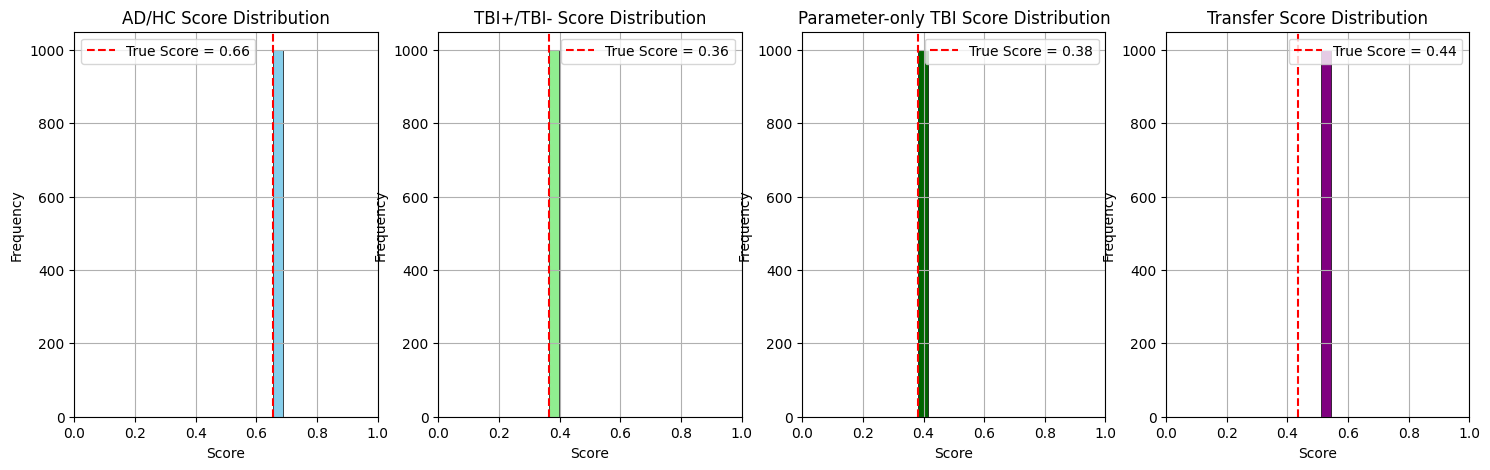

In [8]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 4, figsize=(18, 5), sharex='all', squeeze=True)

# AD Score
axes[0].hist(perm_df["AD Score"], bins=30, color='skyblue', edgecolor='black', linewidth=0.5)
axes[0].axvline(score_ad, color='red', linestyle='--', label=f"True Score = {score_ad:.2f}")
axes[0].set_title("AD/HC Score Distribution")
axes[0].set_xlabel("Score")
axes[0].set_ylabel("Frequency")
axes[0].set_xlim(0,1)
axes[0].grid(True)
axes[0].legend()

# TBI Score
axes[1].hist(perm_df["TBI Score"], bins=30, color='lightgreen', edgecolor='black', linewidth=0.5)
axes[1].axvline(score_tbi, color='red', linestyle='--', label=f"True Score = {score_tbi:.2f}")
axes[1].set_title("TBI+/TBI- Score Distribution")
axes[1].set_xlabel("Score")
axes[1].set_ylabel("Frequency")
axes[1].set_xlim(0,1)
axes[1].grid(True)
axes[1].legend()

# Parameter-only TBI Score
axes[2].hist(perm_df["AD Param-only Score"], bins=30, color='darkgreen', edgecolor='black', linewidth=0.5)
axes[2].axvline(score_param_tbi, color='red', linestyle='--', label=f"True Score = {score_param_tbi:.2f}")
axes[2].set_title("Parameter-only TBI Score Distribution")
axes[2].set_xlabel("Score")
axes[2].set_ylabel("Frequency")
axes[2].set_xlim(0,1)
axes[2].grid(True)
axes[2].legend()

# Transfer Score
# axes[3].hist(perm_df["Transfer Score"], bins=30, color='plum', edgecolor='black')
# axes[3].axvline(score_transfer, color='red', linestyle='--', label=f"True Score = {score_transfer:.2f}")
# axes[3].set_title("Transfer Score Distribution")
# axes[3].set_xlabel("Score")
# axes[3].set_ylabel("Frequency")
# axes[3].set_xlim(0,1)
# axes[3].grid(True)
# axes[3].legend()

# Transfer Scaled Score
axes[3].hist(perm_df["Scaled Transfer Score"], bins=30, color='purple', edgecolor='black', linewidth=0.5)
axes[3].axvline(score_transfer_scaled, color='red', linestyle='--', label=f"True Score = {score_transfer_scaled:.2f}")
axes[3].set_title("Transfer Score Distribution")
axes[3].set_xlabel("Score")
axes[3].set_ylabel("Frequency")
axes[3].set_xlim(0,1)
axes[3].grid(True)
axes[3].legend()

#plt.tight_layout()
plt.show()
